In [386]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 抽卡函数
def draw_card(pool_rate):
    return random.random()<=pool_rate

# 计算delta
def cal_delta(n,N):
    return np.sqrt(np.log(N)/(2*n))

# 计算上置信界
def cal_UCB(est_rate,delta):
    return est_rate+delta

# 数组扩展列
def extend_col(array:np.ndarray):
    return np.hstack((array,array[:,-1:]))

class CardDrawSimulator:   
    def __init__(self,pool_rates:np.ndarray) -> None:
        self.pool_num=pool_rates.size
        self.pool_rates=pool_rates
        self.up_times=self.init_draw()
        self.n=np.ones(self.pool_num,dtype=int).reshape(-1,1)*10
        self.N=self.pool_num*10
        self.est_rates=self.up_times/10
        self.deltas=np.array([cal_delta(self.n[i][-1],self.N) for i in range(self.pool_num)]).reshape(-1,1)
        self.ucbs=np.array([cal_UCB(self.est_rates[i][-1],self.deltas[i][-1]) for i in range(self.pool_num)]).reshape(-1,1)
        self.regret=np.array([0])
    
    # 抽十次卡,返回出货的数量
    def draw_ten_cards(self,pool):
        return np.array([draw_card(self.pool_rates[pool]) for i in range(10)]).sum()
    
    # 对所有卡池进行一次十连抽,返回一个卡池数*1的矩阵数组
    def init_draw(self):
        return np.array([self.draw_ten_cards(i) for i in range(self.pool_num)]).reshape(-1,1)
    
    # 通用步进前摇
    def step_before(self):
        self.up_times=extend_col(self.up_times)
        self.n=extend_col(self.n)
        self.N+=10
        self.est_rates=extend_col(self.est_rates)
        
    # 通用步进后摇
    def step_after(self,active_pool):
        self.regret=np.hstack((self.regret,np.array(self.regret[-1]+self.pool_rates.max()-self.pool_rates[active_pool])))
        draw_result=self.draw_ten_cards(active_pool)
        self.up_times[active_pool][-1]+=draw_result
        self.n[active_pool][-1]+=10
        self.est_rates[active_pool][-1]=self.up_times[active_pool][-1]/self.n[active_pool][-1]
    
    # 采用完全贪心算法进行step次抽卡模拟
    def greedy_sim(self,steps=10):
        for i in range(steps):
            self.step_before()
            active_pool=self.est_rates.T[-1].argmax()
            self.step_after(active_pool)
    
    # 采用ε-贪心算法进行step次抽卡模拟
    def e_greedy_sim(self,steps=10,init_epsilon=0.01,decay=False):
        for i in range(steps):
            self.step_before()
            epsilon=init_epsilon if steps==0 or not decay else init_epsilon/steps
            
            active_pool=self.est_rates.T[-1].argmax() if random.random()<1-epsilon else random.randint(0,self.pool_num-1)
            self.step_after(active_pool)
    
    # 采用UCB算法进行step次抽卡模拟
    def ucb_sim(self,steps=10):
        for i in range(steps):
            self.step_before()
            self.deltas=extend_col(self.deltas)
            self.ucbs=extend_col(self.ucbs)
            
            active_pool=self.ucbs.T[-1].argmax()
            self.step_after(active_pool)
            
            for j in range(self.pool_num):
                self.deltas[j][-1]=cal_delta(self.n[j][-1],self.N)
                self.ucbs[j][-1]=cal_UCB(self.est_rates[j][-1],self.deltas[j][-1])
    
    # 绘图
    def plot(self,pool):
        steps=self.n.shape[1]
        plt.title(f'Card Pool {pool}')
        plt.grid()
        plt.ylim(0,self.pool_rates.max()*10)
        plt.plot(np.linspace(self.pool_rates[pool],self.pool_rates[pool],steps))
        plt.plot(self.est_rates[pool])
        plt.plot(self.deltas[pool])
        plt.plot(self.ucbs[pool])
        plt.legend(['actual_rate','est_rate','delta','ucb'])
    
    # 总结
    def summary(self):
        plt.figure(figsize=(18,6))
        plt.subplot(1,3,1)
        self.plot(0)
        plt.subplot(1,3,2)
        self.plot(1)
        plt.subplot(1,3,3)
        self.plot(2)
        plt.show()
        plt.figure(figsize=(18,6))
        plt.subplot(1,2,1)
        plt.plot(self.n.T)
        plt.legend(['Card Pool 0','Card Pool 1','Card Pool 2'])
        plt.subplot(1,2,2)
        plt.pie(self.n.sum(axis=1),autopct='%1.1f%%')
        plt.legend(['Card Pool 0','Card Pool 1','Card Pool 2'])
        plt.show()

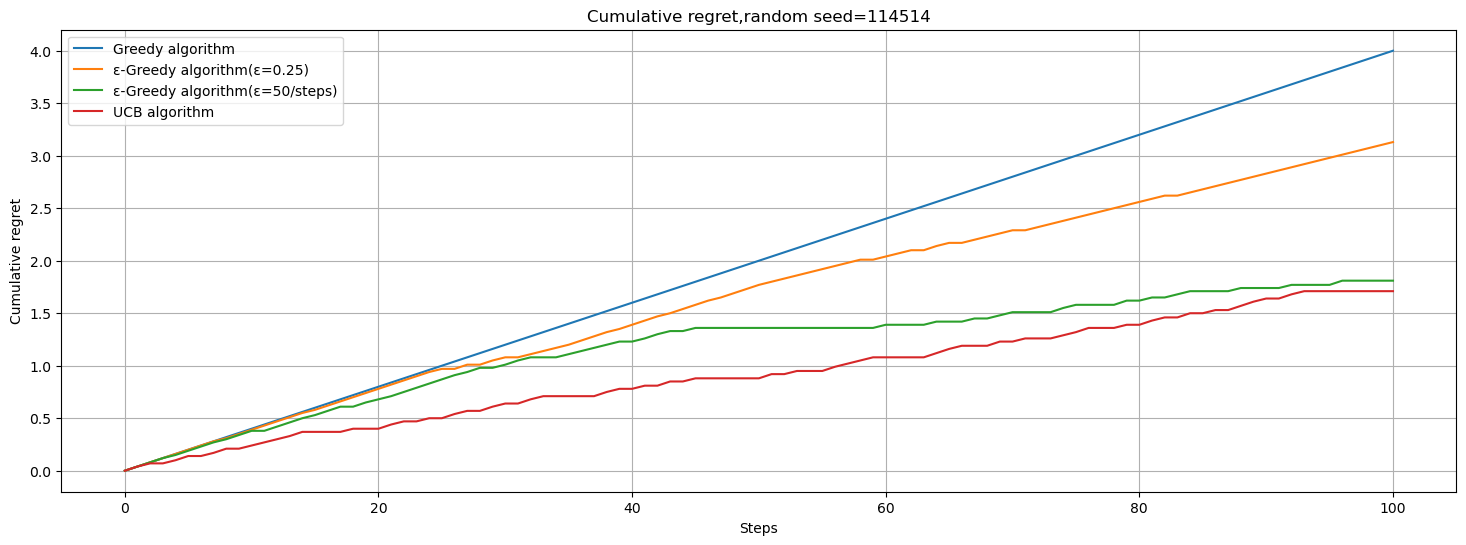

In [387]:
# 比较不同算法策略之间的懊悔差异

# 出货率初始化
pool_rates=np.array([0.01,0.02,0.05])
# 模拟次数
steps=100
# 随机种子
random_seeds=[114514]

for seed in random_seeds:
    random.seed(seed)
    greedy=CardDrawSimulator(pool_rates)
    greedy.greedy_sim(steps)
    random.seed(seed)
    e_greedy=CardDrawSimulator(pool_rates)
    e_greedy.e_greedy_sim(steps,0.25,False)
    random.seed(seed)
    e_decay_greedy=CardDrawSimulator(pool_rates)
    e_decay_greedy.e_greedy_sim(steps,50,True)
    random.seed(seed)
    ucb=CardDrawSimulator(pool_rates)
    ucb.ucb_sim(steps)

    plt.figure(figsize=(18,6))
    plt.title(f'Cumulative regret,random seed={seed}')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative regret')
    plt.plot(greedy.regret)
    plt.plot(e_greedy.regret)
    plt.plot(e_decay_greedy.regret)
    plt.plot(ucb.regret)
    plt.grid()
    plt.legend(['Greedy algorithm','ε-Greedy algorithm(ε=0.25)','ε-Greedy algorithm(ε=50/steps)','UCB algorithm'])
    plt.show()

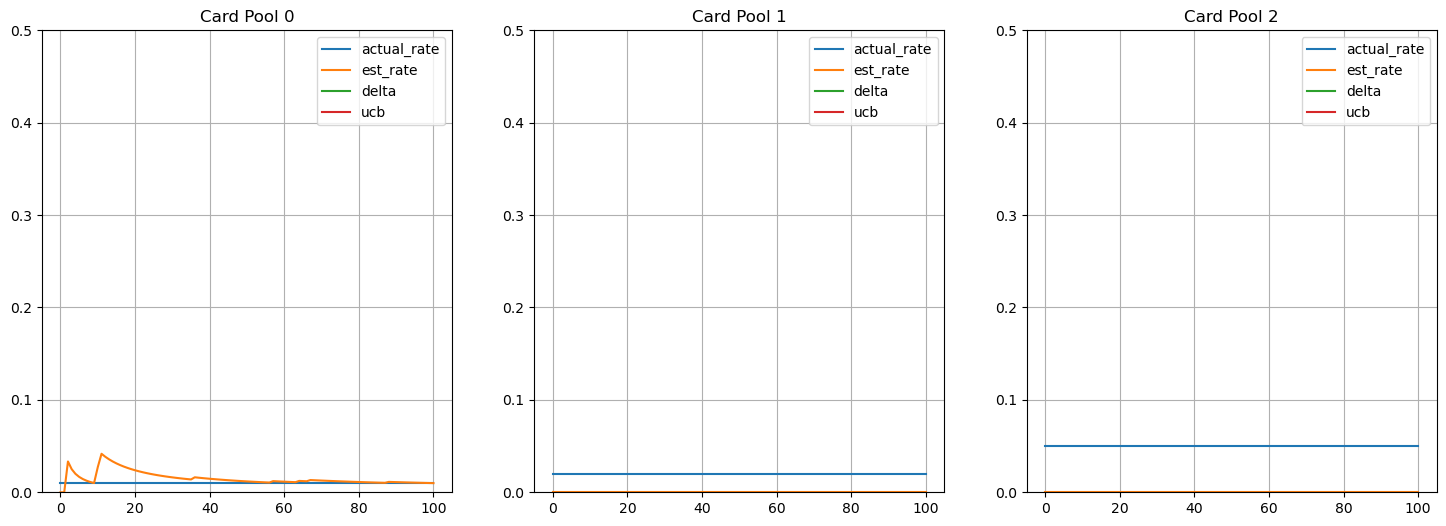

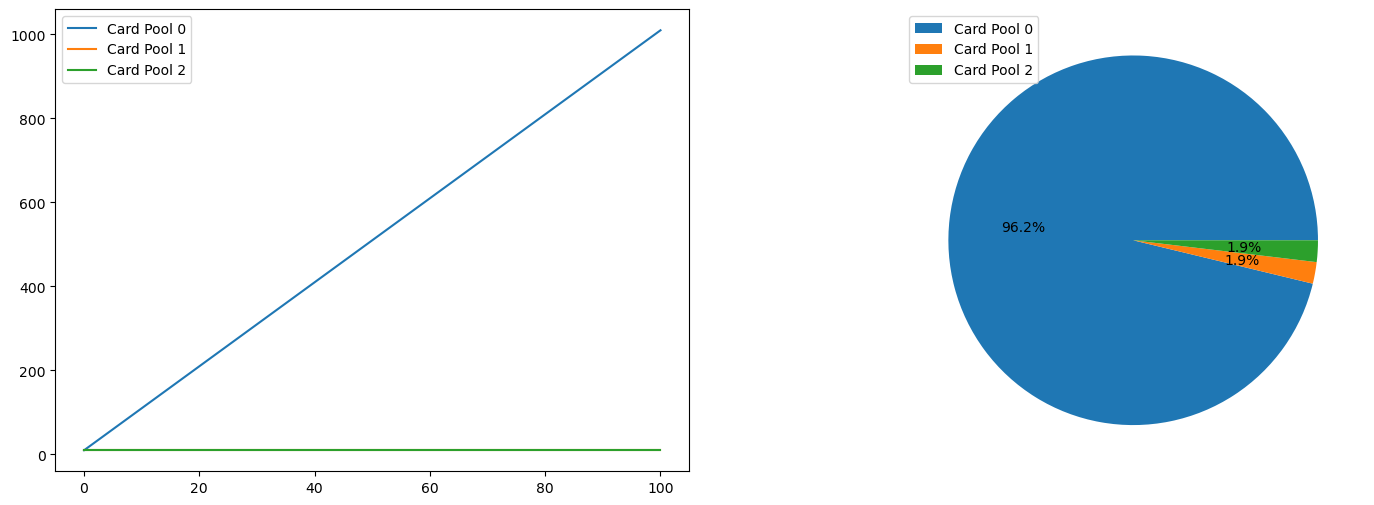

In [388]:
greedy.summary()

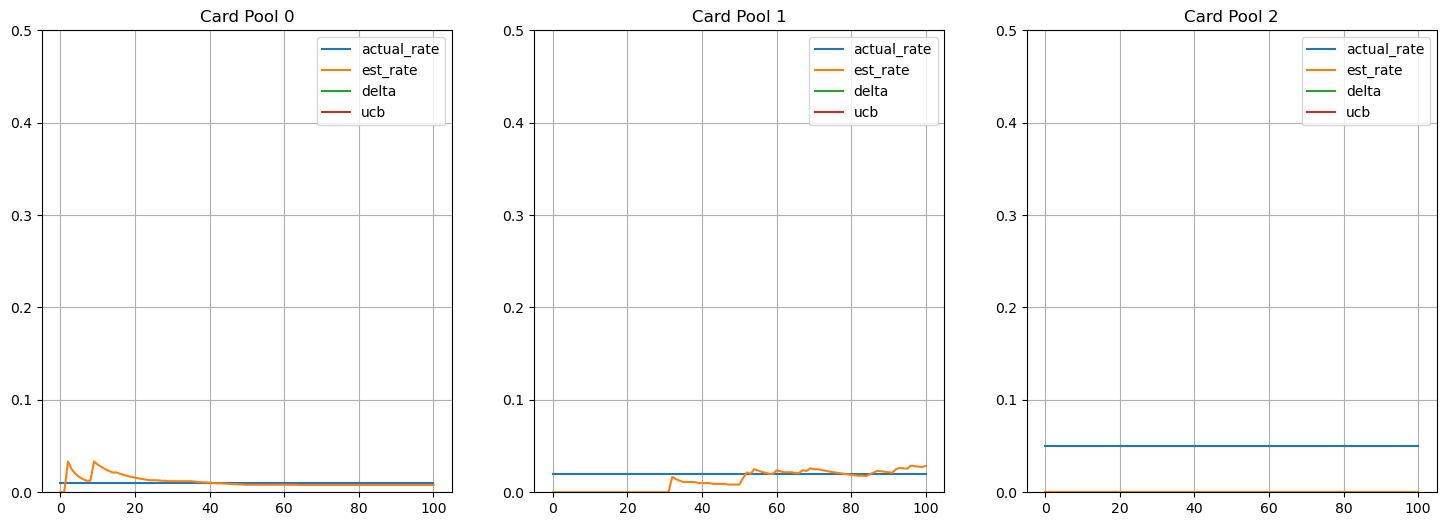

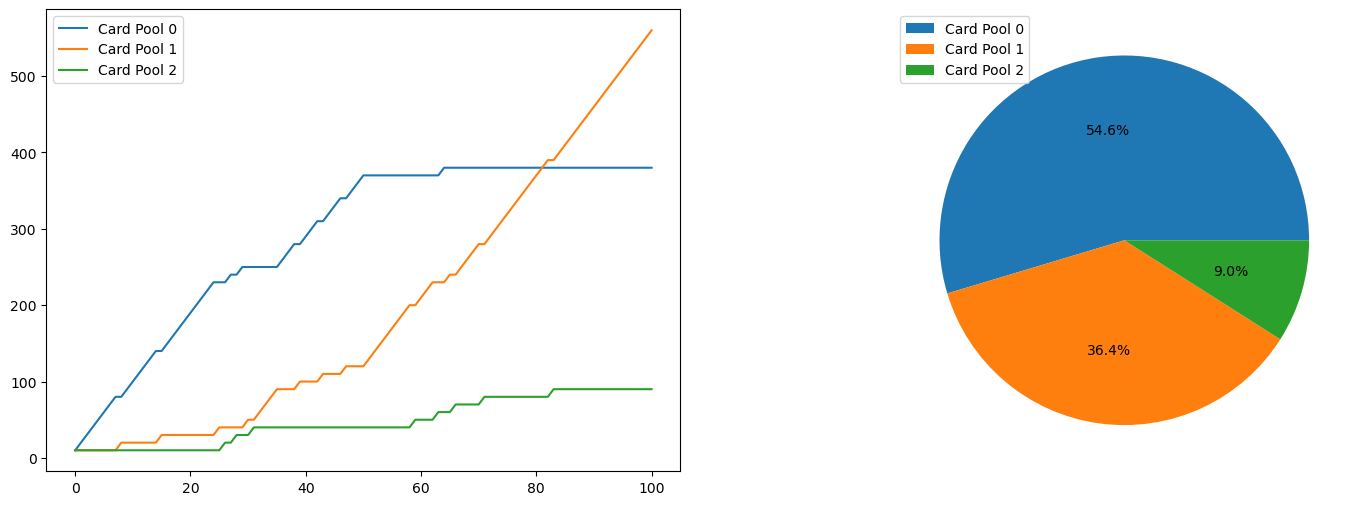

In [389]:
e_greedy.summary()

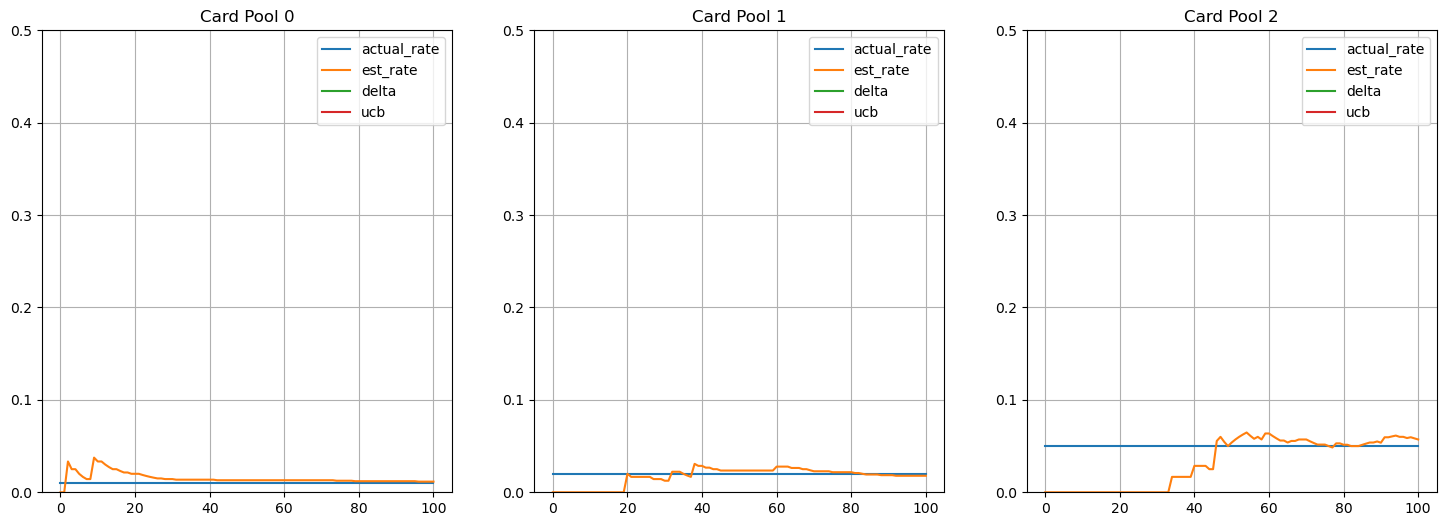

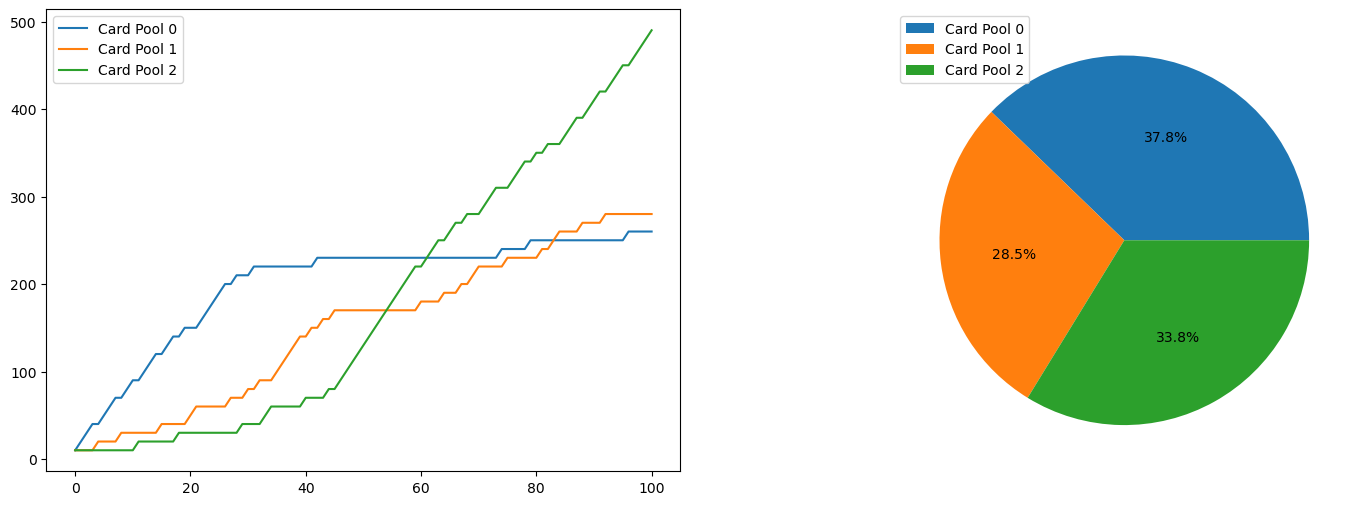

In [390]:
e_decay_greedy.summary()

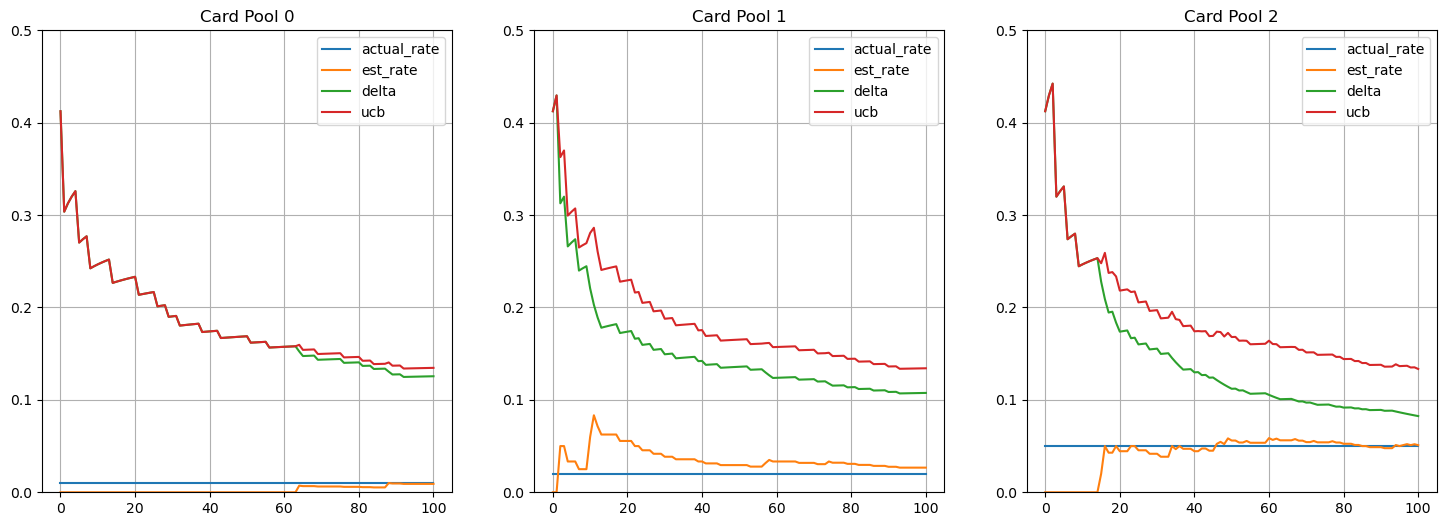

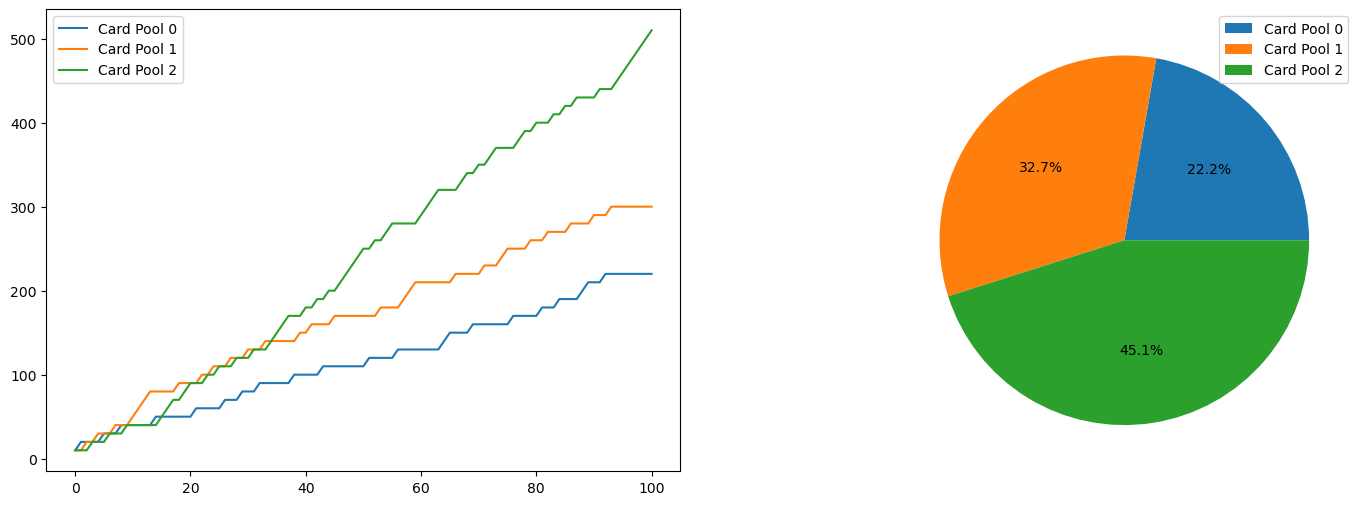

In [391]:
ucb.summary()